In [634]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.integrate import quad
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.integrate import odeint
from scipy.integrate import solve_bvp
from scipy.integrate import solve_ivp
from scipy.interpolate import make_interp_spline
from scipy.fft import fft, ifft, fftfreq
from scipy import constants
from sympy import *

In [635]:
plt.style.use('ggplot')

### Line Parameters

$$
\begin{cases}
L=0.01[m]\\
L_{step}=\frac{0.01}{100}[m]\\
\omega = 2\pi\times 10^{10}\\
Z_L = 1 [k\Omega]\\
z = 0\to L \text{ with steps of } L_{step}[m]
\end{cases}
$$

In [636]:
L = 0.01 # lenght of wire in meters
dL = 100
mu_0 = constants.mu_0
omega = 2*np.pi*10**10 # f=10[GHz]
Z_L = 1 # 1k ohms load
z_vals = np.linspace(0, L, dL)

Extra

In [637]:
vp = constants.speed_of_light/6

## Spatial Reconstruction

In [638]:
E = omega/vp
E

1257.507013171009

$$\Gamma(z)=\frac12 e^{-\frac{\omega}{v_p}z}$$

In [639]:
def Gamma(z):
    return 0.5*np.exp(-E*z)
def dGamma_dz(z):
    return 0.5*(-E)*np.exp(-E*z)

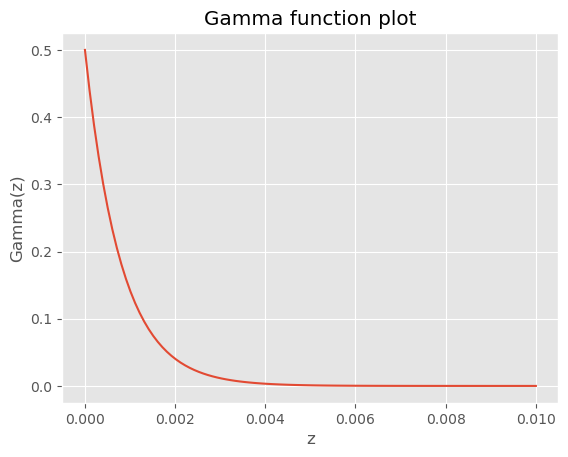

In [640]:
plt.plot(z_vals, Gamma(z_vals))
plt.xlabel('z')
plt.ylabel('Gamma(z)')
plt.title('Gamma function plot')
plt.show()

In [641]:
((np.sqrt(constants.mu_0)/Z_L)**2)/constants.epsilon_0

141925.72923553194

### Derived Solution

$$\epsilon(z)=\left(\frac1{\displaystyle I(L)\frac{Z_L}{\sqrt\mu_0}I^{-1}(z)+I^{-1}(z)\int_L^zI(x)b(x)dx}\right)^2$$

In [642]:
def a(z):
    return -2 * dGamma_dz(z) * 1/(1-(Gamma(z))**2)
def b(z):
    return 4*omega*np.sqrt(mu_0) * (Gamma(z)/(1-(Gamma(z))**2))

In [643]:
def I(z):
    integrand = lambda x: -a(x)
    result, _ = quad(integrand, L, z)
    return np.exp(result)
# Compute the values of I(z) and the integrand
I_values = [I(z) for z in z_vals]
integrand_values = [I(z) * b(z) for z in z_vals]

# Compute the integral using numerical integration
integral_values = []
for i in range(len(z_vals)):
    integral, _ = quad(lambda x: I(x) * b(x), L, z_vals[i])
    integral_values.append(integral)

In [644]:
integrand = lambda x: -a(x)
quad(integrand, L, 0)

(1.0986088315323672, 6.172777517332543e-13)

In [645]:
eps = [ ( (I_values[i])/( I_values[dL-1]*(Z_L/np.sqrt(mu_0)) + 1j*integral_values[i] ) )**2 for i in range(0, dL) ]

In [646]:
integral_values[dL-1]

0.0

In [647]:
(np.sqrt(mu_0)/Z_L)**(2) == eps[dL-1]

True

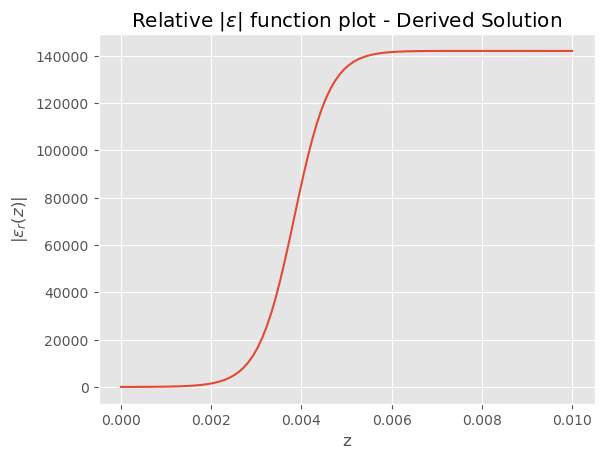

In [648]:
plt.plot(z_vals, [(abs(val)/constants.epsilon_0) for val in eps])
plt.xlabel('z')
plt.ylabel('$|\epsilon_r(z)|$')
plt.title('Relative $|\epsilon|$ function plot - Derived Solution')
plt.show()

### ODE Solution

In [649]:
def d_xi_dz(z, xi):
    return -a(z)*xi-b(z)*xi**2

$$\xi'(z)+a(z)\xi(z)+b(z)\xi^2(z)=0$$

Let $z_r=L-z$. Then we have
$$\xi'(L-z_r)+a(L-z_r)\xi(L-z_r)+b(L-z_r)\xi^2(L-z_r)=0$$

Define $\xi(L-z_r)=\xi_r(z_r)$, $a(L-z_r)=a_r(z_r)$, and $b(L-z_r)=b_r(z_r)$

We solve for $\xi_r(z_r)$ and by substition we have
$$-\xi_r'(z_r)+a_r(z_r)\xi_r(z_r)+b_r(z_r)\xi_r(z_r)^2=0$$

Maunaully change $L$ as required (Required because numerical ODE computaions must have initial condition at z=0 but we have it at z=L)

In [650]:
def a_rev(z):
    return a(0.01-z)
def b_rev(z):
    return b(0.01-z)

In [651]:
a(0) == a_rev(L)

True

In [652]:
def d_xi_r_dz(z, xi_r):
    return a_rev(z)*xi_r+b_rev(z)*xi_r**2

In [653]:
req_xi_r = odeint(d_xi_r_dz, y0=(np.sqrt(mu_0)/Z_L), t=z_vals, tfirst=True)
req_eps_r = np.multiply(req_xi_r, req_xi_r)
req_eps = np.flip(req_eps_r)

/Users/mazz/opt/anaconda3/envs/fproj/lib/python3.10/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [654]:
y = [(abs(val)/constants.epsilon_0) for val in req_eps]
# removing bad values due to inaccuaracies of odeint

for i in range(0, dL-1):
    if (y[i] >= 100* max(eps)):
        y[i] = 0

/Users/mazz/opt/anaconda3/envs/fproj/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


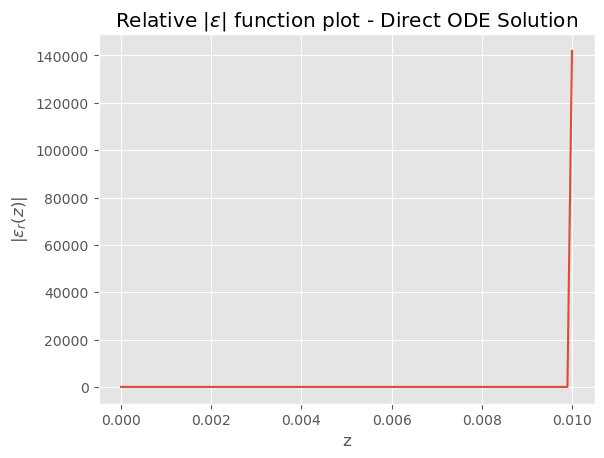

In [655]:
plt.plot(z_vals, y)
plt.xlabel('z')
plt.ylabel('$|\epsilon_r(z)|$')
plt.title('Relative $|\epsilon|$ function plot - Direct ODE Solution')
plt.show()

### Comparison

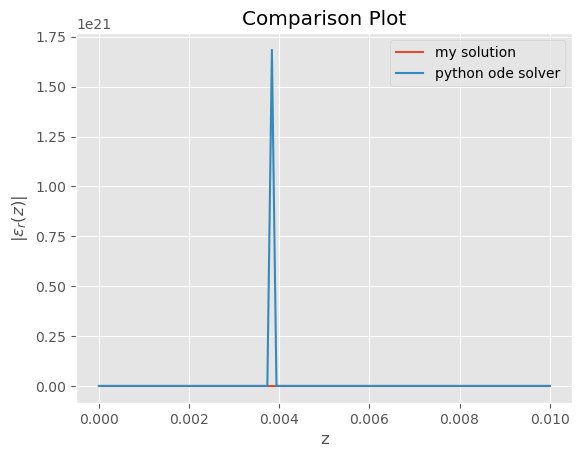

In [656]:
plt.plot(z_vals, [(abs(val)/constants.epsilon_0) for val in eps], label='my solution')
plt.plot(z_vals, [(abs(val)/constants.epsilon_0) for val in req_eps], label='python ode solver')
plt.xlabel('z')
plt.ylabel('$|\epsilon_r(z)|$')
plt.title('Comparison Plot')
plt.legend()
plt.show()

In [657]:
#req_xi = odeint(d_xi_dz, y0=np.sqrt(abs(eps[0])), t=z_vals, tfirst=True)
#req_eps = np.multiply(req_xi, req_xi)

Deviation close to 0 😰

## Temporal Reconstruction

$$\epsilon(t)=\left(\frac1{\displaystyle I(0)\frac1{\xi(0)}I^{-1}(t)+I^{-1}(t)\int_0^t-I(\tau)b(\tau)d\tau}\right)^2$$

In [658]:
np.pi/omega

5e-11

$$\Gamma(t)=\frac12-\frac12 e^{-\omega t}$$

In [659]:
# Defining Gamma
F = omega
def Gamma(t):
    return 0.5-0.5*np.exp(-F*t)
def dGamma_dt(t):
    return -0.5*(-F)*np.exp(-F*t)
# defining a from hese values
def a(t):
    return -2 * dGamma_dt(t) * 1/(1-(Gamma(t))**2)
def b(t):
    return 4*omega*np.sqrt(mu_0) * (Gamma(t)/(1-(Gamma(t))**2))

# convert a and b to arrays
T = 1e-10
dT = 100
t_vals = np.linspace(0, T, dT)

a_r = [a(t_val) for t_val in t_vals]
b_r = [b(t_val) for t_val in t_vals]
I = [ np.exp(quad(a, 0, t_val)[0]) for t_val in t_vals ]

# We first find I(z)b(z) and we interpolate this function
d = [ (I[i]*b_r[i]) for i in range(0, 100) ]
d_interp = interp1d(np.linspace(0, T, 100), d, kind='cubic')
D = [ quad(d_interp, 0, t_val)[0] for t_val in t_vals ]

dGamma_dt_r = [dGamma_dt(t_val) for t_val in t_vals]

Finding limit for the initial condition. Let's say we know that

$$\xi(0)=2\sqrt{\epsilon_0}$$

In [660]:
xi_0 = np.sqrt(30*constants.epsilon_0)
xi_0

1.6298025475007702e-05

$$\xi'(t)-a(t)\xi(t)-b(t)\xi^2(t)=0$$

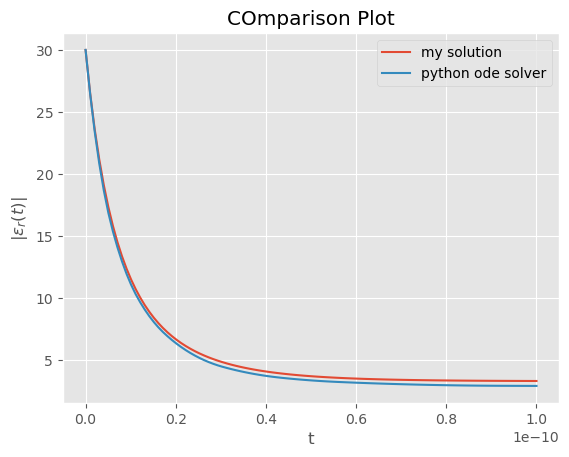

In [661]:
eps = [ ( (I[i])/( I[0]*( 1/xi_0  ) - 1j*D[i] ) )**2 for i in range(0, dT) ]

def d_xi_dt(t, xi):
    return a(t)*xi+b(t)*xi**2

solver_options = {'atol': 1e-6, 'rtol': 1e-4, 'mxstep': 5000}

req_xi = odeint(d_xi_dt, y0=xi_0, t=t_vals, tfirst=True, **solver_options)
req_eps = np.multiply(req_xi, req_xi)

plt.plot(t_vals, [(abs(val)/constants.epsilon_0) for val in eps], label='my solution')
plt.plot(t_vals, [(abs(val)/constants.epsilon_0) for val in req_eps], label='python ode solver')
plt.xlabel('t')
plt.ylabel('$|\epsilon_r(t)|$')
plt.title('COmparison Plot')
plt.legend()
plt.show()